In [2]:
import cv2
import mediapipe as mp
from time import sleep
from e_drone.drone import *
from e_drone.protocol import *

# MediaPipe 손 인식 모델 초기화
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands=1)
mp_draw = mp.solutions.drawing_utils

# 웹캠 캡처 초기화
cap = cv2.VideoCapture(0)

while True:
    drone = Drone()
    drone.open()
    
    drone.sendTakeOff()
    ret, frame = cap.read()
    if not ret:
        break
    
    # 프레임을 BGR에서 RGB로 변환
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frame_rgb)
    
    height, width, _ = frame.shape
    
    # 손이 인식되었는지 확인
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # 검지 손가락 끝의 랜드마크 인덱스
            index_finger_tip_idx = 8
            other_finger_indices = [4, 12, 16, 20]
            
            # 검지 손가락 끝의 x, y 좌표
            index_finger_x = hand_landmarks.landmark[index_finger_tip_idx].x * width
            index_finger_y = hand_landmarks.landmark[index_finger_tip_idx].y * height
            
            # 다른 손가락 끝의 x, y 좌표
            other_fingers_x = [hand_landmarks.landmark[idx].x * width for idx in other_finger_indices]
            other_fingers_y = [hand_landmarks.landmark[idx].y * height for idx in other_finger_indices]
            
            # 손가락 끝점 그리기
            cv2.circle(frame, (int(index_finger_x), int(index_finger_y)), 10, (0, 255, 0), cv2.FILLED)
            for x, y in zip(other_fingers_x, other_fingers_y):
                cv2.circle(frame, (int(x), int(y)), 10, (255, 0, 0), cv2.FILLED)
            
            # 방향 결정
            direction = ""
            
            # 유감스럽게도 이 코드에선 상하좌우가 반대입니다
            
            right_range = min(other_fingers_x) - index_finger_x
            left_range = index_finger_x - max(other_fingers_x)
            down_range = index_finger_y - max(other_fingers_y)
            up_range = min(other_fingers_y) - index_finger_y
            
            if left_range > 0:
                    if up_range > 0:
                        if up_range > left_range:
                            direction = 'go'
                        else:
                            direction = 'left'
                    else:
                        if down_range > left_range:
                            direction = 'back' 
                        else:
                            direction = 'left'
            else:
                    if up_range > 0:
                        if up_range > right_range:
                            direction = 'go'
                        else:
                            direction = 'right'
                    else:
                        if down_range > right_range:
                            direction = 'back'
                        else:
                            direction = 'right' 
               
            # 방향 텍스트 출력
            if direction:
                cv2.putText(frame, direction, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                if direction == 'go':
                    drone.sendControlPosition(1.0, 0, 0, 0.5, 0, 0)
                elif direction == 'back':
                    drone.sendControlPosition(-1.0, 0, 0, 0.5, 0, 0)
                elif direction == 'right':
                    drone.sendControlPosition(0, -1.0, 0, 0.5, 0, 0)
                elif direction == 'left':
                    drone.sendControlPosition(0, 1.0, 0, 0.5, 0, 0)
                else:
                    drone.sendControlWhile(0, 0, 0, 0, 1)
            
            # 손 랜드마크 그리기
            mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
    
    # 결과 프레임을 보여줌
    cv2.imshow('Hand Tracking', frame)
    
    # 'q' 키를 누르면 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# 자원 해제
drone.sendLanding()
drone.close()
cap.release()
cv2.destroyAllWindows()


c:\Users\dlwns\Desktop\Study\myenv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


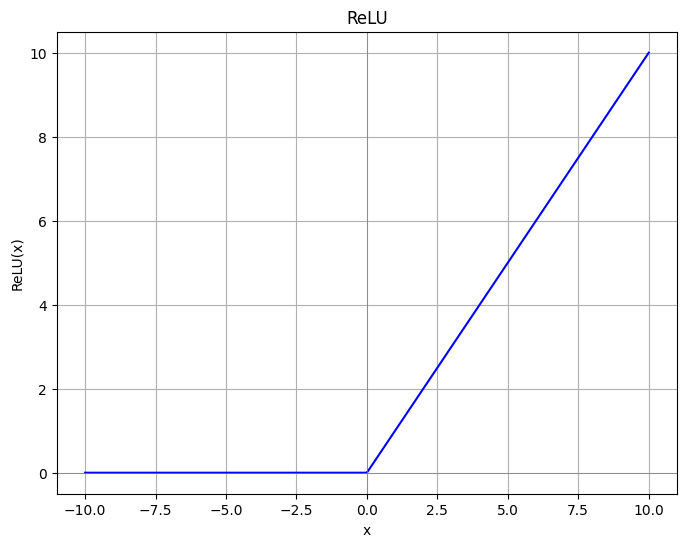

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# ReLU 함수 정의
def relu(x):
    return np.maximum(0, x)

# x 값 범위 설정
x = np.linspace(-10, 10, 400)
y = relu(x)

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='ReLU', color='blue')
plt.title('ReLU')
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.grid(True)
plt.show()